# Movement data analysis

Analyze the movement data collected during the experiment

## Import data and libraries

In [98]:
import geopandas as gpd
import pandas as pd
import folium
from folium.plugins import HeatMap
from branca.colormap import linear
from geolib import geohash as geolib
import json
import math
import random
import arc_drawer
import numpy as np
import pydeck as pdk
import matplotlib.pyplot as plt
import seaborn as sns

In [99]:

# Read the data from the csv
df = pd.read_csv('data/steps.csv', sep=";")
df_mov = pd.read_csv('data/Test_Movements.csv', sep=";")
df_device = pd.read_csv('data/devices.csv', sep=";")
df

,participant_id,day,steps
0,12W4H1U,2025-05-19,8140
1,12W4H1U,2025-05-20,4161
2,12W4H1U,2025-05-21,5902
3,12W4H1U,2025-05-17,5589
4,12W4H1U,2025-05-18,5278
...,...,...,...
2022,3S8R1G,2025-06-19,10560
2023,3S8R1G,2025-06-20,12187
2024,3S8R1G,2025-06-21,10712
2025,3S8R1G,2025-06-22,11725


In [100]:
# Convert 'day' column to datetime
df['day'] = pd.to_datetime(df['day']).dt.date

# Set 'day' as index and sort by 'day'
df.set_index('day', inplace=True)
df.sort_index(inplace=True)

# Create a new DataFrame to store the result
result = pd.DataFrame()

# Process each participant individually
for participant in df['participant_id'].unique():
    # Get the subset for the current participant
    participant_df = df[df['participant_id'] == participant]
    
    # Create a complete date range from the first to the last day for this participant
    date_range = pd.date_range(start=participant_df.index.min(), end=participant_df.index.max())
    
    # Reindex the participant's data to include all dates in the range
    participant_df = participant_df.reindex(date_range)
    
    # Fill missing 'participant_id' values with the current participant ID
    participant_df['participant_id'] = participant
    
    # Append the processed data for this participant to the result
    result = pd.concat([result, participant_df])

# Reset index to make 'day' a column again
result.reset_index(inplace=True)
result.rename(columns={'index': 'day'}, inplace=True)

In [101]:
df_steps = result

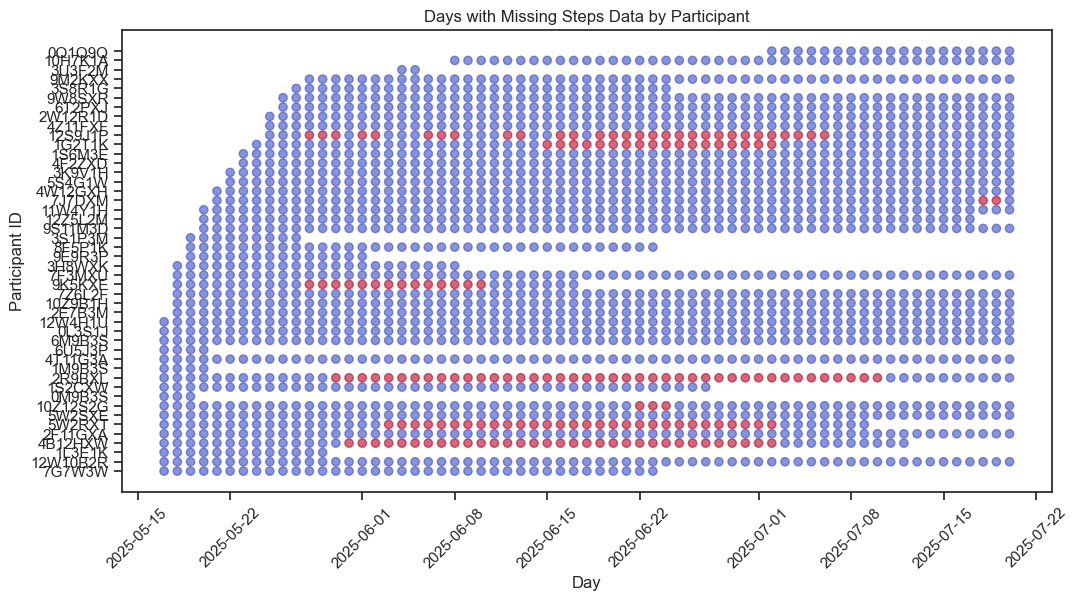

In [102]:
# Plot the days where there is a NA value in the steps column. x axis is the day, y axis is the participant_id
sns.set_theme()
sns.set_style("ticks")
plt.figure(figsize=(12, 6))
plt.scatter(result['day'], result['participant_id'], c=result['steps'].isna(), cmap='coolwarm', alpha=0.6)
plt.title('Days with Missing Steps Data by Participant')
plt.xlabel('Day')
plt.ylabel('Participant ID')
plt.xticks(rotation=45)
plt.show()

In [103]:
df_mov

,participant_id,start_time,end_time,start_geohash,end_geohash,distance(m),mean_of_transport,original_mean_of_transport,gCO2,is_power_saving
0,12W4H1U,2025-05-22 15:02:53+00:00,2025-05-22 15:05:51+00:00,u0qnnq,u0qnnr,681,ON_BICYCLE,ON_BICYCLE,3,True
1,12W4H1U,2025-05-22 15:08:18+00:00,2025-05-22 15:32:01+00:00,u0qnnr,u0qjd3,19425,TRAIN,TRAIN,135,True
2,12W4H1U,2025-05-22 15:32:46+00:00,2025-05-22 15:52:19+00:00,u0qjd3,u0qjd1,945,WALKING,WALKING,0,True
3,12W4H1U,2025-05-22 17:11:56+00:00,2025-05-22 17:25:47+00:00,u0qjd4,u0qjd1,622,WALKING,WALKING,0,True
4,12W4H1U,2025-05-22 20:15:32+00:00,2025-05-22 20:44:11+00:00,u0qjd1,u0qnnq,20481,TRAIN,TRAIN,143,True
...,...,...,...,...,...,...,...,...,...,...
5867,3S8R1G,2025-06-05 06:23:49+00:00,2025-06-05 06:34:44+00:00,u0qnnq,u0qnnv,2364,ON_BICYCLE,ON_BICYCLE,13,False
5868,3S8R1G,2025-06-05 10:37:31+00:00,2025-06-05 10:53:06+00:00,u0qnnv,u0qnnq,2285,ON_BICYCLE,ON_BICYCLE,12,False
5869,3S8R1G,2025-06-05 11:53:41+00:00,2025-06-05 12:03:31+00:00,u0qnnq,u0qnny,2296,ON_BICYCLE,ON_BICYCLE,12,False
5870,3S8R1G,2025-06-05 15:42:53+00:00,2025-06-05 16:15:22+00:00,u0qnny,u0qnny,339,WALKING,WALKING,0,False


In [104]:
# For movements, compute the number of movements per day, for all days between the first and last day with data for that user
df_mov['day'] = pd.to_datetime(df_mov['start_time']).dt.date
df_temp = df_mov.groupby(['participant_id', 'day']).size().reset_index(name='movements')

# Ensure 'day' column in df_temp is datetime64[ns] to match df_steps
df_temp['day'] = pd.to_datetime(df_temp['day'])

# Merge the steps and movements dataframes on 'participant_id' and 'day'
result = pd.merge(df_steps, df_temp, on=['participant_id', 'day'], how='outer', suffixes=('_steps', '_movements'))

# Fill Nan in movements with 0
result['movements'].fillna(0, inplace=True)

result

,day,participant_id,steps,movements
0,2025-05-17,7G7W3W,4818.0,0.0
1,2025-05-18,7G7W3W,2767.0,0.0
2,2025-05-19,7G7W3W,1497.0,0.0
3,2025-05-20,7G7W3W,2683.0,0.0
4,2025-05-21,7G7W3W,6326.0,0.0
...,...,...,...,...
2249,2025-07-15,5L11NXI,NaN,7.0
2250,2025-07-16,5L11NXI,NaN,17.0
2251,2025-07-17,5L11NXI,NaN,11.0
2252,2025-07-18,5L11NXI,NaN,1.0


In [105]:
# Add a column to indicate if the participant has:
# - steps and movements data (steps != nan and movements > 0) -> 0
# - only steps data (steps != nan and movements == 0) -> 1
# - only movements data (steps == nan and movements > 0) -> 2
# - no data (steps == nan and movements == 0) -> 3
result['has_data'] = np.where((result['steps'].notna()) & (result['movements'] > 0), 0,
                                np.where((result['steps'].notna()) & (result['movements'] == 0), 1,
                                         np.where((result['steps'].isna()) & (result['movements'] > 0), 2, 3)))


In [106]:
# For each participant, add a column to indicate the device used
result = pd.merge(result, df_device[['participant_id', 'device']], on='participant_id', how='left')
result['device'].fillna('Unknown', inplace=True)

In [114]:
# If the device contains 'iphone' set column shape to 'x' otherwise set it to 'o'
result['shape'] = result['device'].apply(lambda x: 'o' if 'iphone' in x.lower() else '*')

/var/folders/hc/bxt7k06n5532f1ws84vbg7180000gn/T/ipykernel_68109/1139235050.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = plt.cm.get_cmap('viridis', 4)


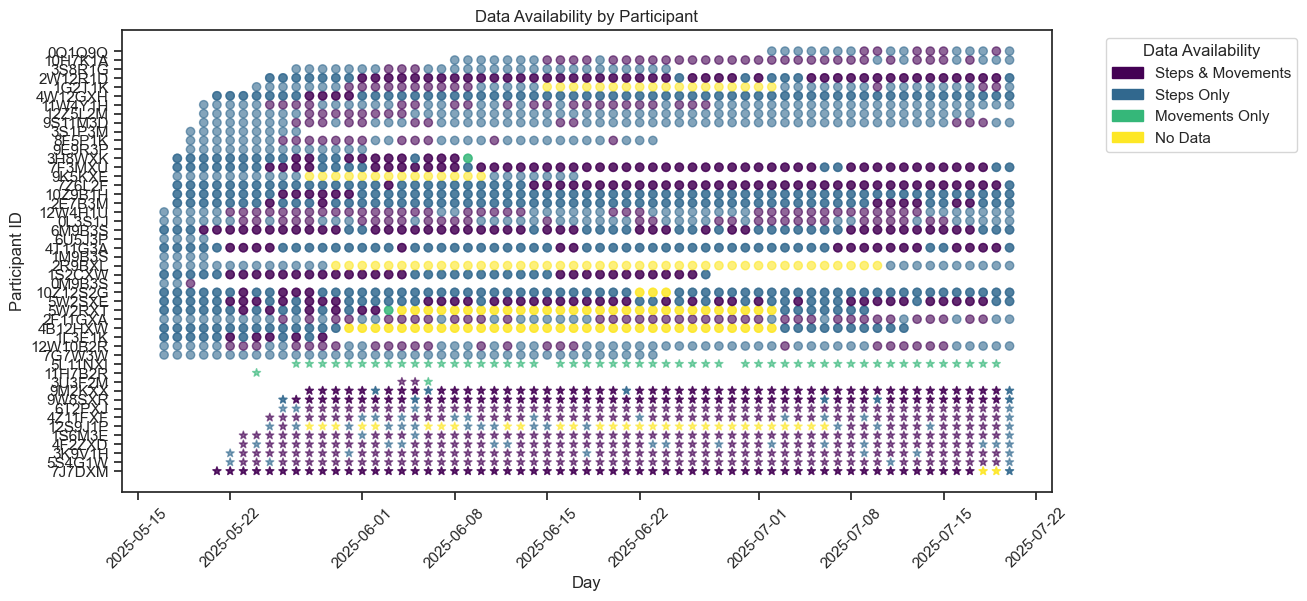

In [115]:
# Plot the has_data column for each day. x axis is the day, y axis is the participant_id, has_data is the color of the point
sns.set_theme()
sns.set_style("ticks")
plt.figure(figsize=(12, 6))
# Iterate over each unique shape
for shape, group in result.groupby('shape'):
    plt.scatter(group['day'], group['participant_id'], c=group['has_data'], marker=shape, label=f'Shape: {shape}', cmap='viridis', alpha=0.6)
plt.title('Data Availability by Participant')
plt.xlabel('Day')
plt.ylabel('Participant ID')
plt.xticks(rotation=45)
# Add custom legend with labels Steps & Movements, Steps Only, Movements Only, No Data and the colors used in the scatter plot (0, 1, 2, 3 on the viridis colormap)
import matplotlib.patches as mpatches

# Define the labels and colors for the 4 categories in the viridis colormap
labels = ['Steps & Movements', 'Steps Only', 'Movements Only', 'No Data']
viridis = plt.cm.get_cmap('viridis', 4)
handles = [mpatches.Patch(color=viridis(i), label=labels[i]) for i in range(4)]

plt.legend(handles=handles, title='Data Availability', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()